In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import collections

# Cấu hình thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Xây dựng Vocabulary ---
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        frequencies = collections.Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in sentence.lower().split():
                frequencies[word] += 1
                
        for word, count in frequencies.items():
            if count >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = text.lower().split()
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# --- 2. Xây dựng Dataset ---
class Flickr8kDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        # Lấy captions và ảnh
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        # Xây dựng vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

# --- 3. Collate Function (Padding) ---
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        return imgs, targets

# --- Thiết lập Path và Loader ---
# Lưu ý: Cấu trúc thư mục trên Kaggle thường là /kaggle/input/flickr8k/Images và captions.txt
image_folder = '/kaggle/input/flickr8k/Images'
captions_file = '/kaggle/input/flickr8k/captions.txt'

transform = transforms.Compose([
    transforms.Resize((224, 224)), # ResNet chuẩn input 224
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Load dữ liệu (Cần đảm bảo file tồn tại, nếu không code sẽ báo lỗi)
try:
    dataset = Flickr8kDataset(image_folder, captions_file, transform=transform)
    pad_idx = dataset.vocab.stoi["<PAD>"]
    train_loader = DataLoader(
        dataset=dataset,
        batch_size=32, # Batch size theo yêu cầu
        num_workers=2,
        shuffle=True,
        collate_fn=MyCollate(pad_idx=pad_idx)
    )
    print(f"Vocab size: {len(dataset.vocab)}")
except Exception as e:
    print(f"Lỗi load data: {e}. Hãy kiểm tra lại đường dẫn file trên Kaggle.")

Using device: cuda
Vocab size: 3005


In [2]:
import torchvision.models as models

# --- Encoder ---
class CNNEncoder(nn.Module):
    def __init__(self, out_dim=512):
        super().__init__()
        # Sử dụng weights mặc định thay vì pretrained=True (cú pháp mới)
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Bỏ avgpool và fc layers cuối cùng
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        self.proj = nn.Conv2d(2048, out_dim, kernel_size=1)
        
    def forward(self, x):
        f = self.cnn(x)  # B x 2048 x 7 x 7
        f = self.proj(f) # B x out_dim x 7 x 7
        B, D, H, W = f.shape
        
        # Flatten feature map thành memory cho attention
        memory = f.flatten(2).permute(0, 2, 1) # B x (H*W) x D
        global_vec = f.mean(dim=[2, 3])        # B x D
        return global_vec, memory

# --- Attention ---
class AdditiveAttention(nn.Module):
    def __init__(self, dim_q, dim_k, dim_h):
        super().__init__()
        self.Wq = nn.Linear(dim_q, dim_h)
        self.Wk = nn.Linear(dim_k, dim_h)
        self.v = nn.Linear(dim_h, 1)

    def forward(self, q, k, mask=None):
        # q: B x hidden_dim, k: B x L x mem_dim
        q_ = self.Wq(q).unsqueeze(1)    # B x 1 x dim_h
        k_ = self.Wk(k)                 # B x L x dim_h
        
        # Broadcasting q_ cộng với k_
        attn_energy = self.v(torch.tanh(q_ + k_)).squeeze(-1) # B x L
        
        if mask is not None:
            attn_energy = attn_energy.masked_fill(mask == 0, -1e9)
            
        alpha = torch.softmax(attn_energy, dim=-1) # B x L
        context = torch.bmm(alpha.unsqueeze(1), k).squeeze(1) # B x mem_dim
        
        return context, alpha

# --- Decoder ---
class LSTMAttnDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, mem_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim + mem_dim, hidden_dim, batch_first=True)
        self.attn = AdditiveAttention(dim_q=hidden_dim, dim_k=mem_dim, dim_h=256) # dim_h=256 theo bài
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim

    def forward(self, captions, memory):
        # captions: B x T
        B, T = captions.shape
        embeddings = self.emb(captions) # B x T x Emb
        
        # Khởi tạo hidden state và cell state
        h = torch.zeros(1, B, self.hidden_dim, device=captions.device)
        c = torch.zeros(1, B, self.hidden_dim, device=captions.device)
        
        outputs = []
        # Loop qua từng time step (Teacher Forcing)
        for t in range(T):
            h_curr = h[-1] # Lấy layer cuối cùng
            
            # Tính attention context
            context, _ = self.attn(h_curr, memory)
            
            # Input cho LSTM: ghép embedding từ hiện tại + context vector
            lstm_input = torch.cat([embeddings[:, t, :], context], dim=1).unsqueeze(1) # B x 1 x (Emb+Mem)
            
            out, (h, c) = self.lstm(lstm_input, (h, c))
            
            logits = self.fc(out.squeeze(1))
            outputs.append(logits.unsqueeze(1))
            
        return torch.cat(outputs, dim=1)

    def generate_caption(self, memory, vocab, max_len=20):
        # Hàm dùng cho inference (tạo caption cho 1 ảnh)
        # memory: 1 x L x D
        batch_size = memory.size(0)
        h = torch.zeros(1, batch_size, self.hidden_dim, device=memory.device)
        c = torch.zeros(1, batch_size, self.hidden_dim, device=memory.device)
        
        # Bắt đầu bằng thẻ <SOS>
        input_word = torch.tensor([vocab.stoi["<SOS>"]], device=memory.device)
        
        captions = []
        attentions = []
        
        for _ in range(max_len):
            embed = self.emb(input_word) # 1 x Emb
            h_curr = h[-1]
            
            context, alpha = self.attn(h_curr, memory)
            attentions.append(alpha.cpu().detach())
            
            lstm_input = torch.cat([embed, context], dim=1).unsqueeze(1)
            out, (h, c) = self.lstm(lstm_input, (h, c))
            
            output = self.fc(out.squeeze(1))
            predicted_idx = output.argmax(1)
            
            captions.append(predicted_idx.item())
            
            if predicted_idx.item() == vocab.stoi["<EOS>"]:
                break
                
            input_word = predicted_idx
            
        return [vocab.itos[idx] for idx in captions], attentions

# --- Tổng hợp Model ---
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, images, captions):
        _, memory = self.encoder(images)
        outputs = self.decoder(captions, memory)
        return outputs

In [3]:
# Hyperparameters
embed_dim = 256
hidden_dim = 512
mem_dim = 512 # Output dim của Encoder
vocab_size = len(dataset.vocab)
learning_rate = 3e-4
num_epochs = 3 # Train thử 3 epoch

# Khởi tạo mô hình
encoder = CNNEncoder(out_dim=mem_dim).to(device)
decoder = LSTMAttnDecoder(vocab_size, embed_dim, hidden_dim, mem_dim).to(device)
model = ImageCaptioningModel(encoder, decoder).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- Training Loop ---
print("Bắt đầu huấn luyện...")
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for idx, (imgs, captions) in enumerate(train_loader):
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        # Forward
        # Caption input vào decoder là từ <SOS> đến từ sát cuối (bỏ <EOS>)
        # Target là từ thứ 2 đến <EOS>
        outputs = model(imgs, captions[:, :-1])
        
        # Reshape để tính loss
        targets = captions[:, 1:]
        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        if idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
            
    print(f"--- Kết thúc Epoch {epoch+1}, Avg Loss: {epoch_loss/len(train_loader):.4f} ---")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]


Bắt đầu huấn luyện...
Epoch [1/3], Step [0/1265], Loss: 8.0126
Epoch [1/3], Step [100/1265], Loss: 4.3876
Epoch [1/3], Step [200/1265], Loss: 4.1698
Epoch [1/3], Step [300/1265], Loss: 3.8180
Epoch [1/3], Step [400/1265], Loss: 3.7010
Epoch [1/3], Step [500/1265], Loss: 3.4531
Epoch [1/3], Step [600/1265], Loss: 3.2567
Epoch [1/3], Step [700/1265], Loss: 3.2193
Epoch [1/3], Step [800/1265], Loss: 3.1329
Epoch [1/3], Step [900/1265], Loss: 3.0885
Epoch [1/3], Step [1000/1265], Loss: 3.0803
Epoch [1/3], Step [1100/1265], Loss: 2.9402
Epoch [1/3], Step [1200/1265], Loss: 2.8125
--- Kết thúc Epoch 1, Avg Loss: 3.4834 ---
Epoch [2/3], Step [0/1265], Loss: 2.7763
Epoch [2/3], Step [100/1265], Loss: 3.0295
Epoch [2/3], Step [200/1265], Loss: 2.9519
Epoch [2/3], Step [300/1265], Loss: 2.7601
Epoch [2/3], Step [400/1265], Loss: 2.6962
Epoch [2/3], Step [500/1265], Loss: 2.5859
Epoch [2/3], Step [600/1265], Loss: 2.5228
Epoch [2/3], Step [700/1265], Loss: 2.5668
Epoch [2/3], Step [800/1265], Los


--- KẾT QUẢ DỰ ĐOÁN ---
Caption dự đoán: a snowboarder is doing a trick on a snowboard . <EOS>


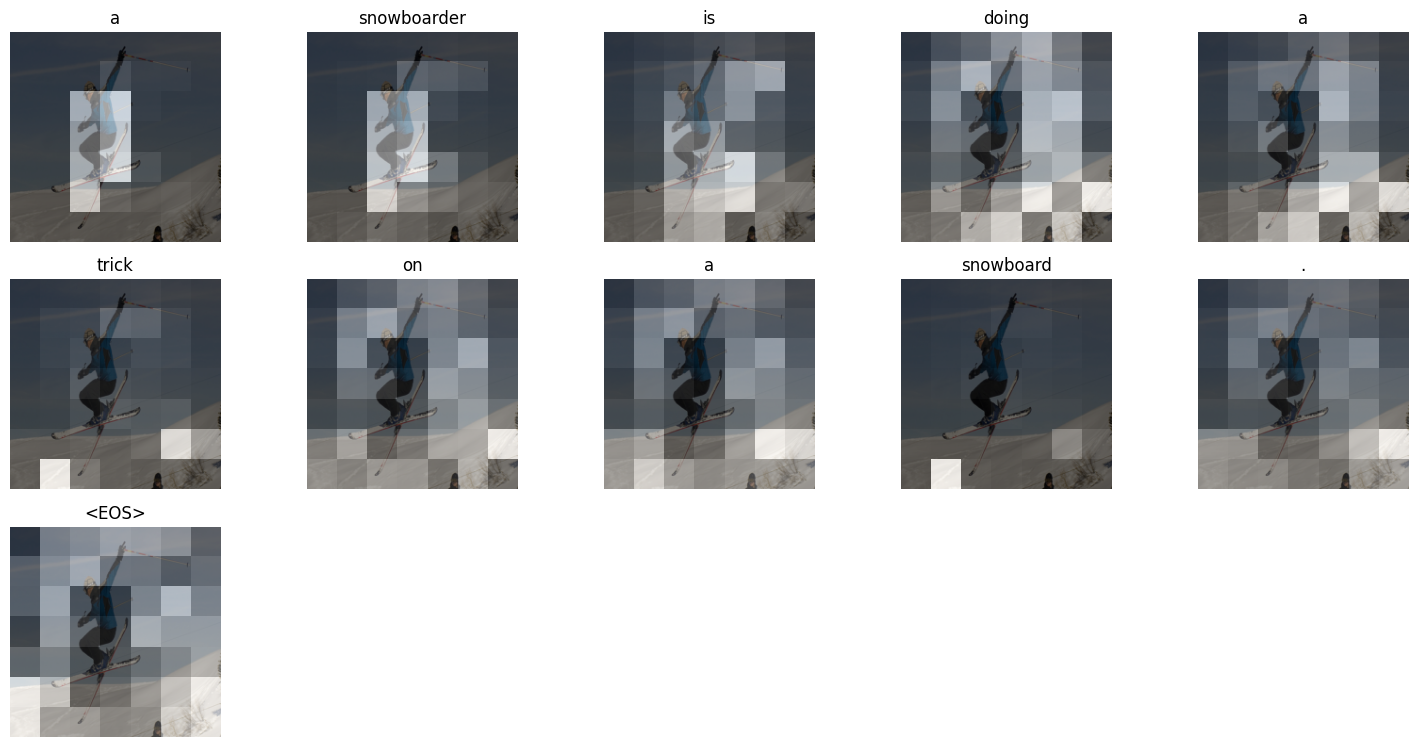

Caption dự đoán: three dogs run through a field . <EOS>


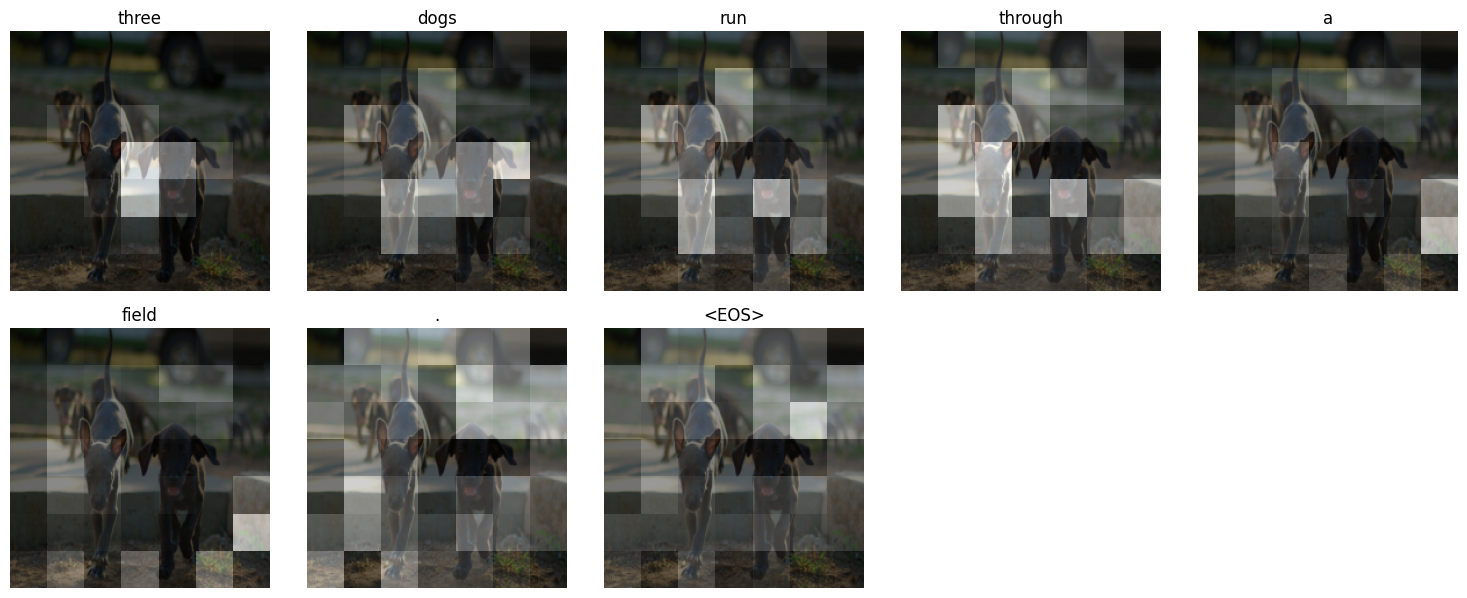

Caption dự đoán: two dogs are playing in a field . <EOS>


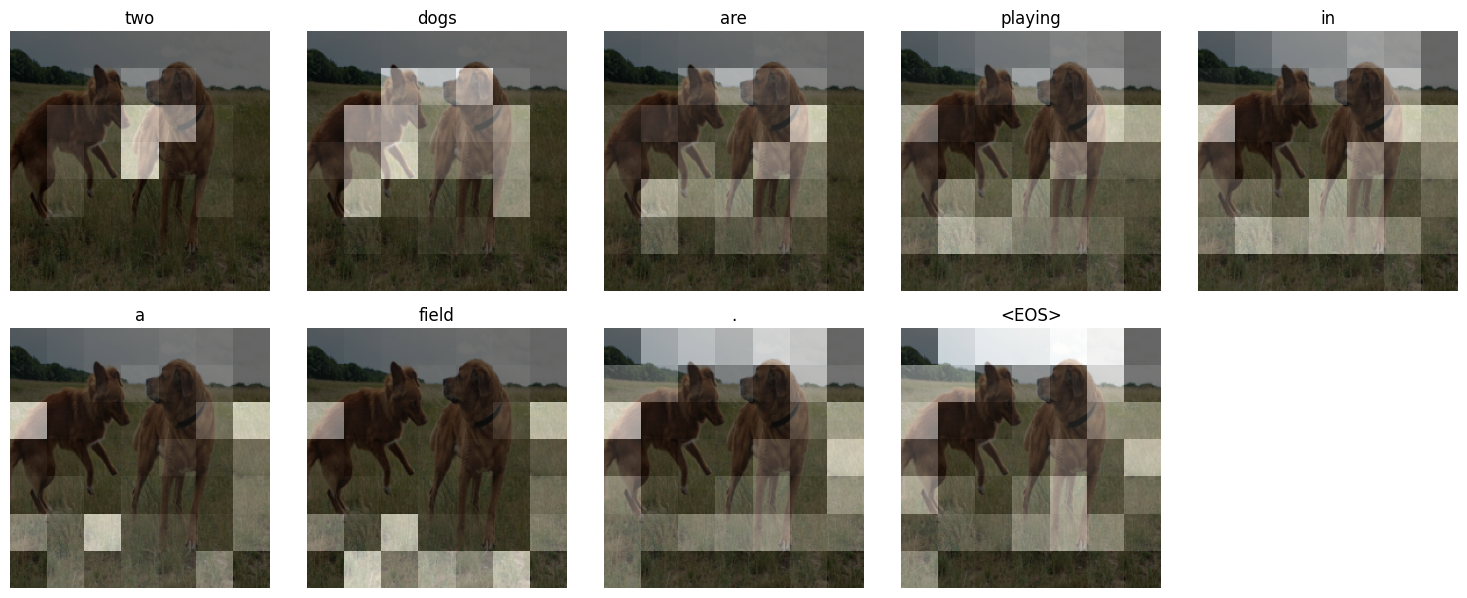

Caption dự đoán: a man rides a bike on a dirt bike . <EOS>


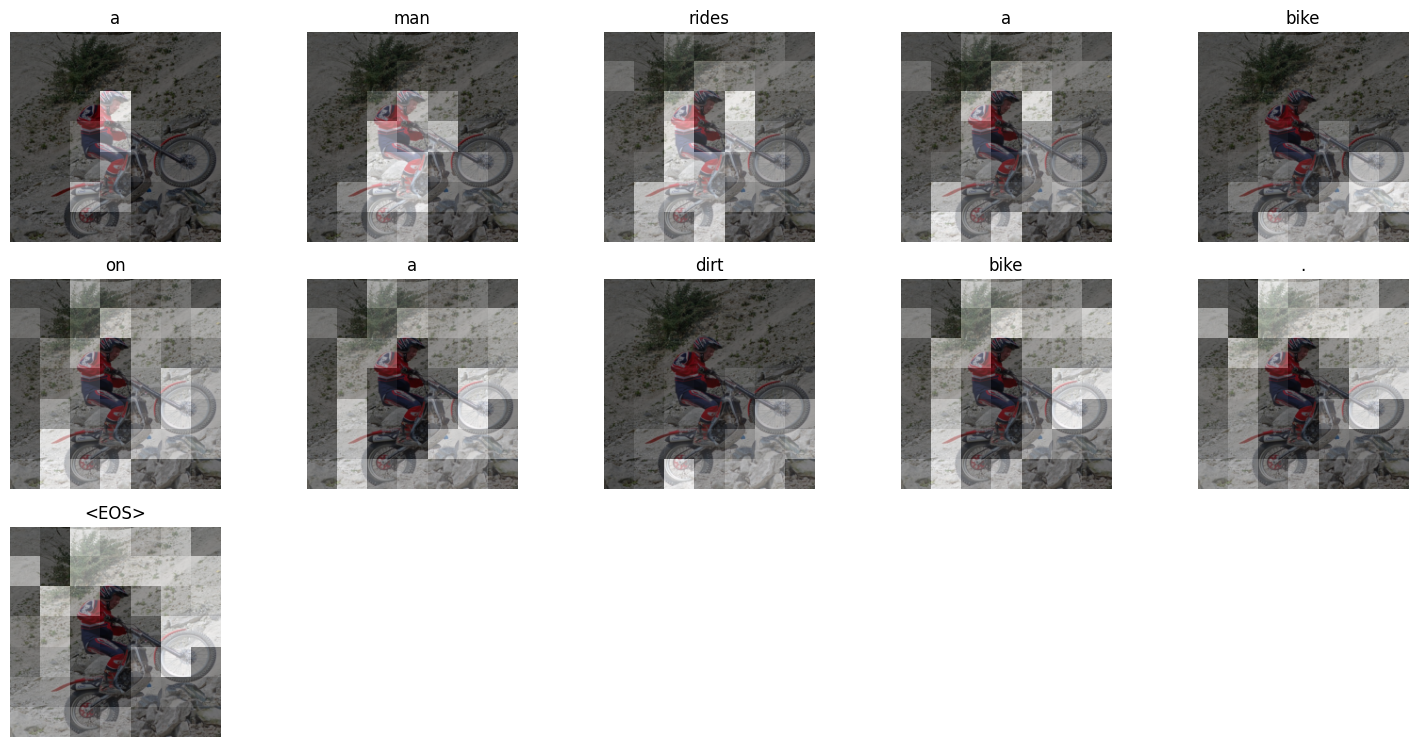

Caption dự đoán: a group of dogs pulling a sled through the snow . <EOS>


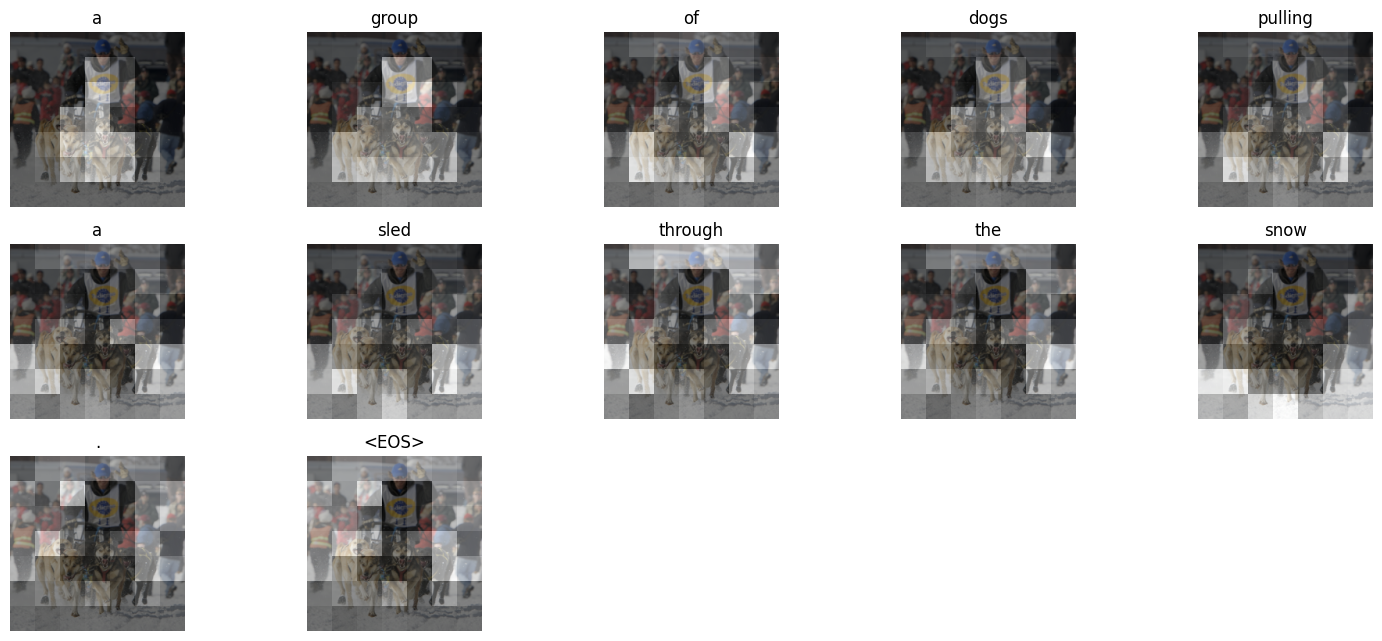

In [4]:
def plot_attention(img, result, attention_plot):
    # img: PIL Image
    # result: list of generated words
    # attention_plot: numpy array (len_caption, 49) -> 49 vì 7x7
    
    img = img.resize((224, 224))
    fig = plt.figure(figsize=(15, 15))
    
    len_result = len(result)
    for l in range(len_result):
        if l >= 15: break # Giới hạn hiển thị 15 từ đầu
        
        temp_att = attention_plot[l].reshape(7, 7) # Reshape lại thành lưới 7x7
        
        ax = fig.add_subplot(len_result//2 + 1, 5, l+1)
        ax.set_title(result[l])
        img_ax = ax.imshow(img)
        
        # Resize attention map lên 224x224 để đè lên ảnh
        # Dùng skimage hoặc scipy.ndimage.zoom để mượt hơn, ở đây dùng extent của matplotlib cho đơn giản
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img_ax.get_extent())
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Chạy thử trên 5 ảnh ---
model.eval()
print("\n--- KẾT QUẢ DỰ ĐOÁN ---")

# Lấy 5 mẫu từ dataset
indices = np.random.choice(len(dataset), 5, replace=False)

for idx in indices:
    img_tensor, _ = dataset[idx] # img_tensor shape (3, 224, 224)
    
    # Chuẩn bị ảnh cho encoder (thêm batch dimension)
    img_input = img_tensor.unsqueeze(0).to(device)
    
    # Encoder trích xuất đặc trưng
    with torch.no_grad():
        _, memory = encoder(img_input) # 1 x 49 x 512
        
        # Decoder sinh từ
        caption, attentions = decoder.generate_caption(memory, dataset.vocab)
    
    # Xử lý attention để vẽ
    # attentions là list các tensor (1, 49), convert sang numpy array
    att_mat = torch.cat(attentions).numpy() # (len_cap, 49)
    
    # Hiển thị
    # Cần convert tensor ảnh về PIL Image để vẽ
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_origin = inv_normalize(img_tensor)
    img_origin = img_origin.permute(1, 2, 0).numpy()
    img_origin = np.clip(img_origin, 0, 1)
    img_pil = Image.fromarray((img_origin * 255).astype(np.uint8))

    print(f"Caption dự đoán: {' '.join(caption)}")
    plot_attention(img_pil, caption, att_mat)

## **Phân tích câu hỏi (3.5)**

   ### **(a) GAP vs HxW:**

        GAP (Global Average Pooling): Nén toàn bộ không gian H×W thành 1 vector duy nhất. Nó làm mất thông tin vị trí (spatial information). Decoder chỉ biết "có con mèo" nhưng không biết nó nằm đâu.

        Giữ H×W (Attention): Giữ lại lưới đặc trưng 7×7. Decoder có thể "nhìn" (attend) vào góc trên bên trái khi sinh từ "bầu trời" và nhìn vào giữa khi sinh từ "con mèo". Đây là mấu chốt để caption chính xác hơn với ảnh phức tạp.

   ### **(b) Lợi ích với ảnh nhiều vật thể nhỏ:**

        Khi có nhiều vật thể nhỏ, GAP sẽ lấy trung bình cộng đặc trưng của tất cả, làm "nhòe" các chi tiết nhỏ.

        Cơ chế Attention với L=H⋅W cho phép mô hình tập trung trọng số (attention weight) cao vào đúng vùng pixel chứa vật thể nhỏ đó tại thời điểm cần sinh từ tương ứng, giúp nhận diện và mô tả chúng tốt hơn.